# Homework (18 pts) - PCA

## Nisha Dalal nd8288

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

%config InlineBackend.figure_format = 'retina'

In [2]:
from scipy.io import loadmat

# Same data file as used in lecture.
# Avaliable in lecture folder or in homework folder.
data = loadmat('eeg.mat')

# grab relevant data, EEG units are microvolts (uV), time is in milliseconds (ms)
# each channel is an electrode, each trial is a separate EEG recording from that electrode
eeg = data["EEG"][0,0]["data"]  # [channel, time point, trial]
time = data["EEG"][0,0]["times"][0]

eeg.shape, time.shape

((64, 640, 99), (640,))

---
1. (3 pts) From the EEG data above, generate the average EEG across trials for each channel for times between 0 and 500 ms (note that the first time point is NOT time zero). Plot the result for channel 20.

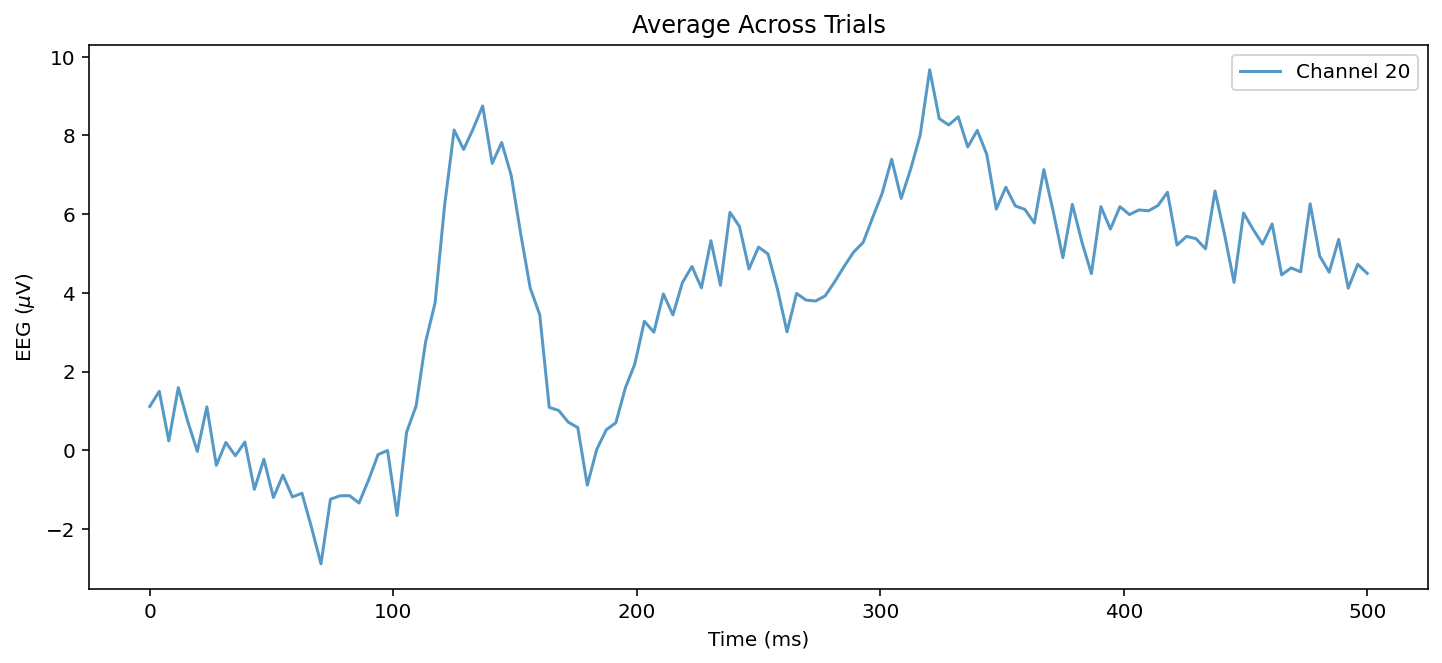

In [3]:
time_0 = np.where(time == 0)
time_500 = np.where(time == 500)
time_0_500 = time[256:385]

eeg_500 = eeg[:,256:385,:]
eeg_500.shape, time_0_500.shape

eeg_avg = eeg_500.mean(axis=2)
eeg_avg.shape

plt.figure(figsize=(12,5))
plt.plot(time_0_500, eeg_avg[20,:], label="Channel 20", alpha=0.75)
plt.xlabel('Time (ms)')
plt.ylabel('EEG ($\mu$V)')
plt.title('Average Across Trials')
plt.legend()
plt.show()

---
2. (3 pts) Apply PCA to the averaged EEGs from #1 above. Use as many principal components (PCs) as needed to explain 90% of the variance in the EEG waveforms. Report the number of PCs used and plot each PC as if it were an EEG waveform itself.

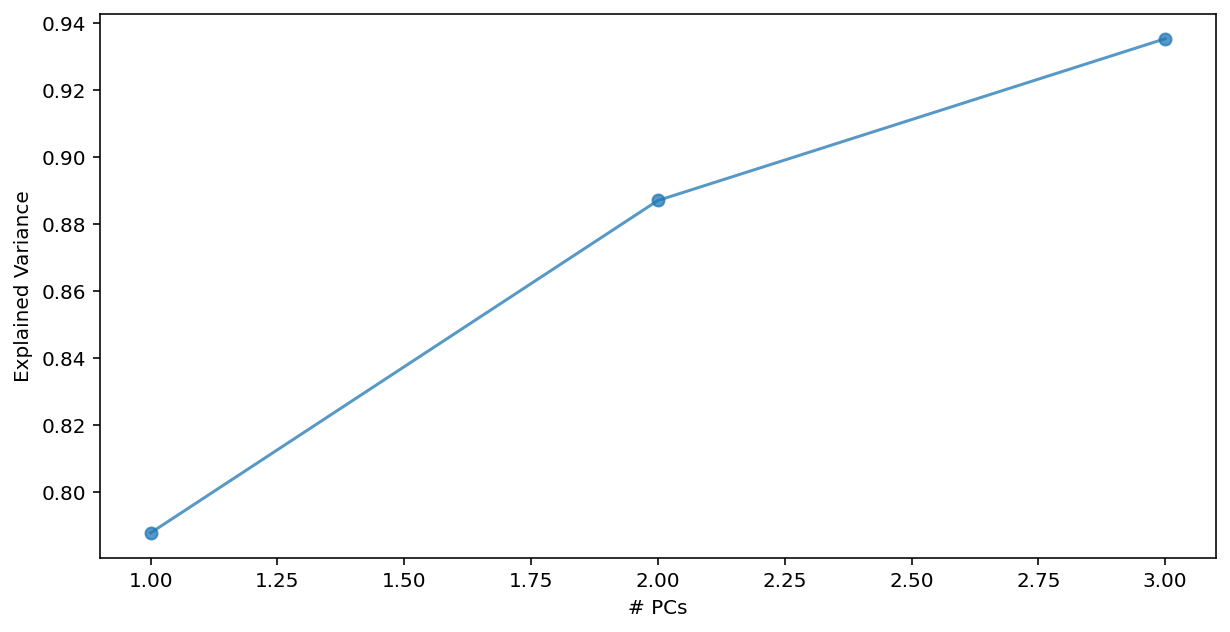

In [4]:
pca = PCA(3) 
pca.fit(eeg_avg) 

plt.figure(figsize=(10,5))
plt.plot(np.arange(1, 4), np.cumsum(pca.explained_variance_ratio_), 'o-', alpha=0.75)
plt.xlabel('# PCs')
plt.ylabel('Explained Variance')
plt.show()

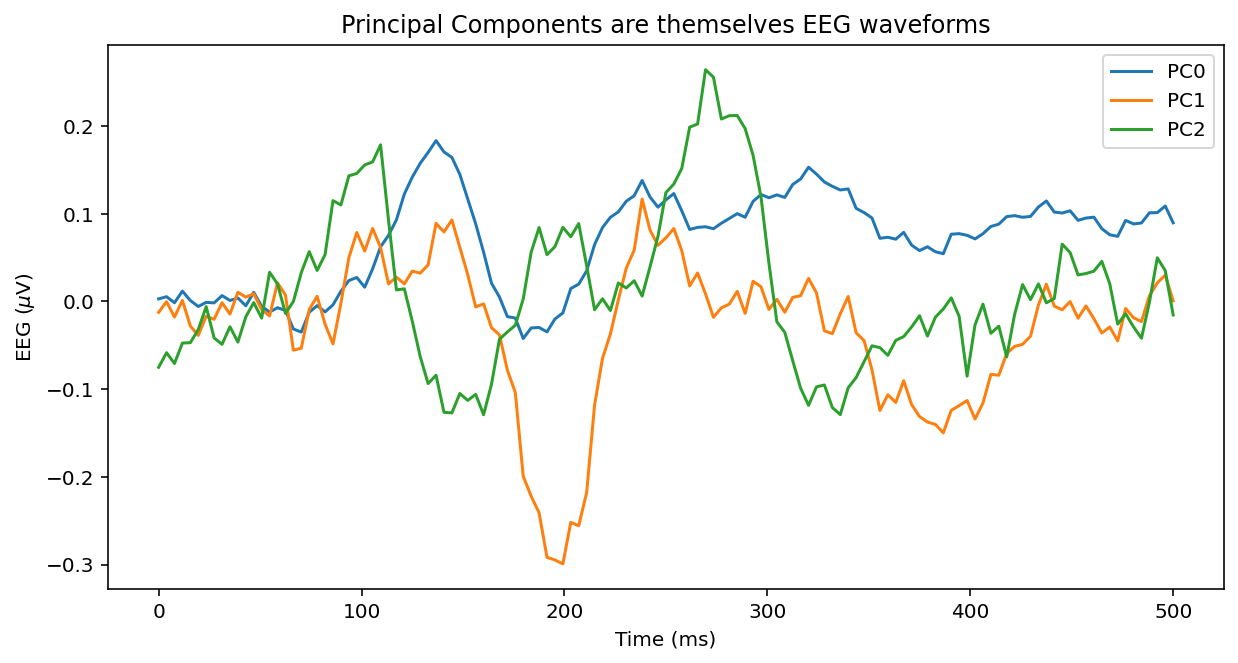

In [5]:
plt.figure(figsize=(10,5))
for i in range(3):
    plt.plot(time_0_500, pca.components_[i,:], label=f'PC{i}')
plt.xlabel('Time (ms)')
plt.ylabel('EEG ($\mu$V)')
plt.title('Principal Components are themselves EEG waveforms')
plt.legend()
plt.show()

---
3. (3 pts) Replot the average EEG for channel 20 as in #1 above, and additionally overlay the plot of its projection onto the principal components from #2 above. Use a legend to label the plots as 'original' and 'projected'. Does it look like we lost a lot of information by describing each waveform using only a small number of PCs as opposed to explicit values at each time point?

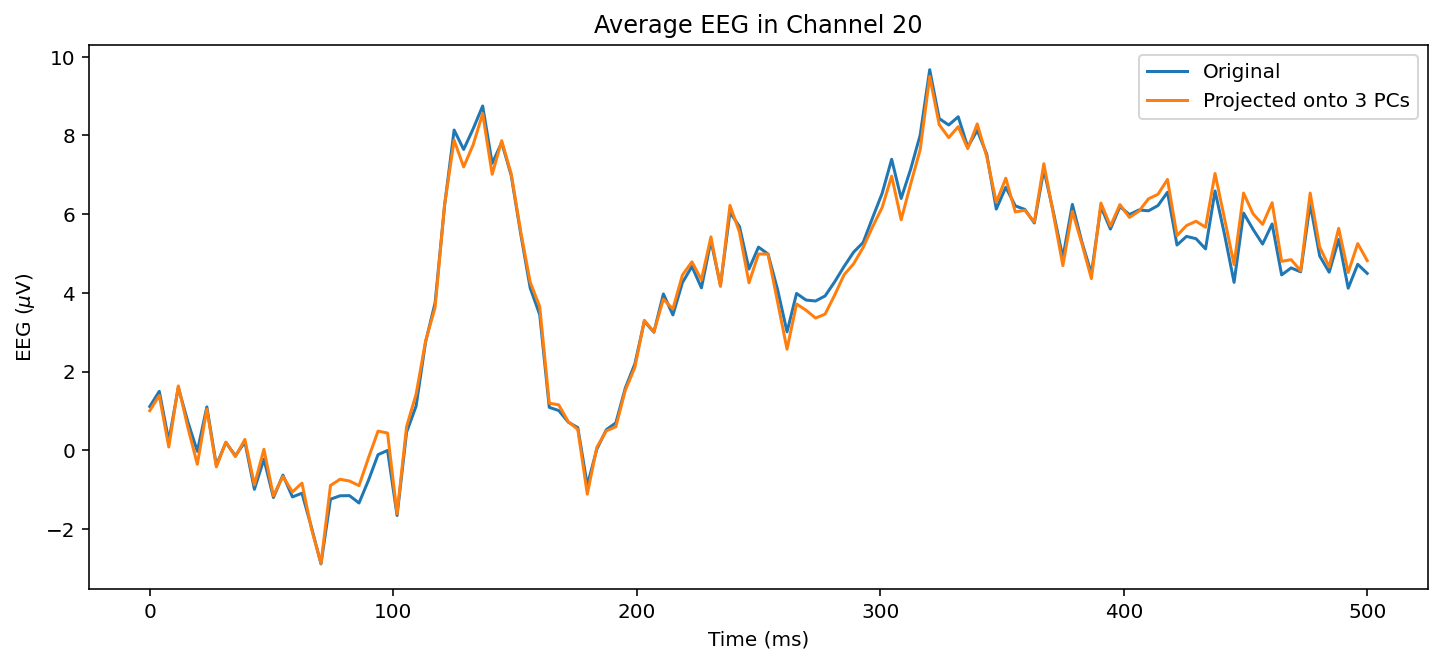

In [6]:
channel_20_og = eeg_avg[20,:]

eeg_avg_mix_pc = pca.transform(eeg_avg)
eeg_avg_pca_Projected = pca.inverse_transform(eeg_avg_mix_pc)

plt.figure(figsize=(12,5))
plt.plot(time_0_500, channel_20_og, label="Original")
plt.plot(time_0_500, eeg_avg_pca_Projected[20,:], label="Projected onto 3 PCs")
plt.xlabel('Time (ms)')
plt.ylabel('EEG ($\mu$V)')
plt.title('Average EEG in Channel 20');
plt.legend()
plt.show()

Very little information appears to have been lost using only three principal components to describe the entire EEG waveform.

---
4. (3 pts) How much of each of the PCs were mixed together to generate the projection for channel 20 as shown in #3 above? Plot the relative amounts of each PC as a bar graph. Use only a single tick mark on the x-axis for each PC.

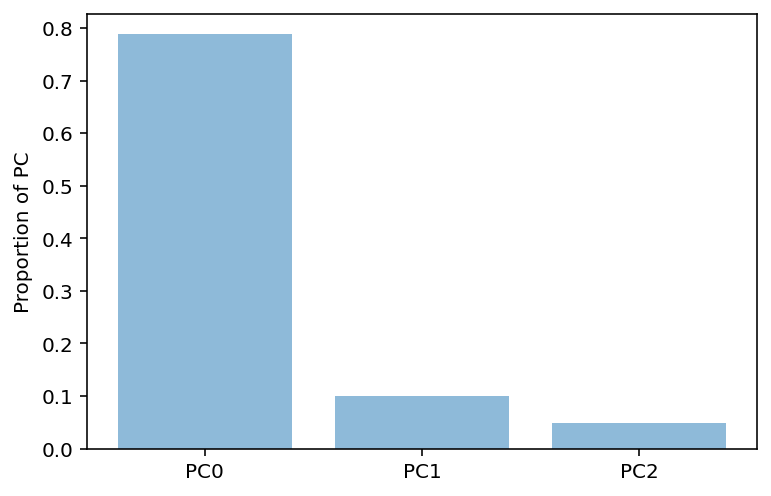

In [7]:
plt.bar(range(3), pca.explained_variance_ratio_[0:3], alpha=0.5)
plt.xticks(range(3), labels = ["PC0", "PC1", "PC2"])
plt.ylabel('Proportion of PC')
plt.show()

---
5. (3 pts) Use a Gaussian mixture model (GMM) to group the EEG waveforms into three clusters in the PCA reduced dimensions. Plot the EEG waveforms as points in the PCA reduced dimensions (axes are the PCs) colored according to their cluster.

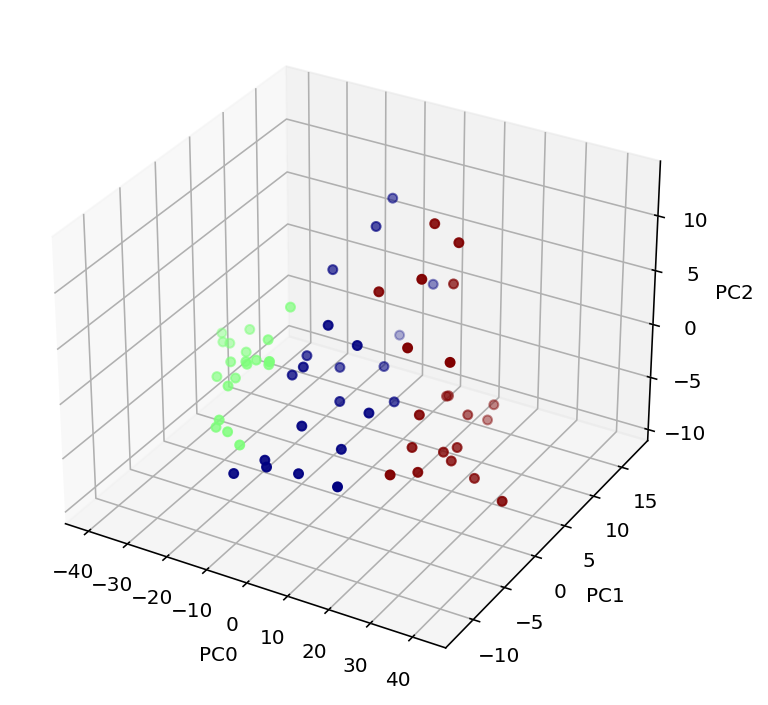

In [8]:
n_components = np.arange(1, 3)
models = [GaussianMixture(n_components=n, random_state=0) for n in n_components]
for m in models:
    m.fit(eeg_avg_mix_pc)
    
n = 3
gmm = GaussianMixture(n_components=n)
label = gmm.fit_predict(eeg_avg_mix_pc)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(eeg_avg_mix_pc[:,0], eeg_avg_mix_pc[:,1], eeg_avg_mix_pc[:,2], c=label, cmap='jet')
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
fig.tight_layout();

---
6. (3 pts) For each of the three clusters from #5 above, plot all of the averaged EEGs belonging to that cluster overlaid on each other. Thus, you'll have a separate plot for each cluster. Additionally, overlay on each plot the average EEG for that cluster plotted as a black line.

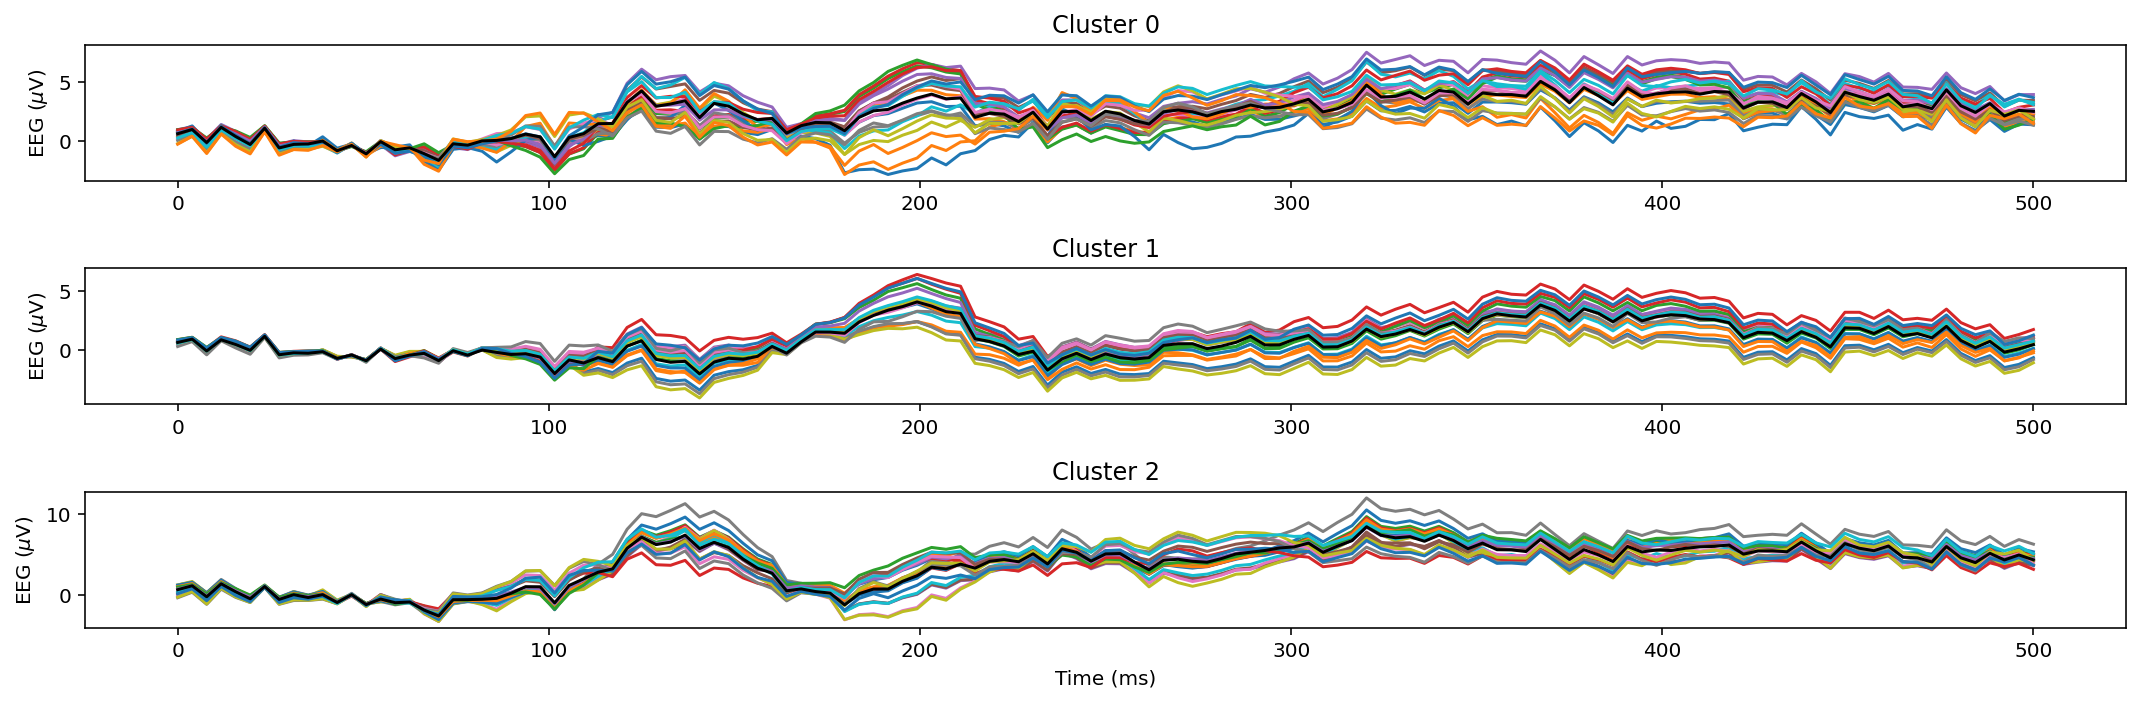

In [9]:
eeg_avg_pca_Projected = pca.inverse_transform(eeg_avg_mix_pc)

[fig, ax] = plt.subplots(3, 1, figsize=(15,5))
for channel in range(64):
    cluster = label[channel]
    ax[cluster].plot(time_0_500, eeg_avg_pca_Projected[channel,:])
    
for clusters in range(3):
    mask = (label == clusters)
    eeg_in = eeg_avg[mask,:]
    ax[clusters].plot(time_0_500, eeg_in.mean(axis=0), color = "black")
    
ax[0].set_ylabel('EEG ($\mu$V)')
ax[0].set_title('Cluster 0')

ax[1].set_ylabel('EEG ($\mu$V)')
ax[1].set_title('Cluster 1')

ax[2].set_xlabel('Time (ms)')
ax[2].set_ylabel('EEG ($\mu$V)')
ax[2].set_title('Cluster 2')
fig.tight_layout();